<a href="https://colab.research.google.com/github/Eunchan24/Image-Classification-and-Object-Detection/blob/main/Image_Classification%20/Image_Classification_MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 준비

In [143]:
# library import
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
import tensorflow as tf
from tensorflow import keras
import re
import shutil
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D


In [144]:
# 버전확인 
print('Tensorflow :',tf.__version__)
print('Keras :',keras.__version__)

Tensorflow : 2.5.0
Keras : 2.5.0


In [145]:
# dataset 폴더 만들기
dataset_dir = os.makedirs('dataset', exist_ok=True)

In [146]:
# data load // https://www.robots.ox.ac.uk/~vgg/data/pets/
%cd /content/dataset/
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

/content/dataset
--2021-06-17 05:45:07--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz.1’

annotations.tar.gz. 100%[===================>]  18.28M  58.8MB/s    in 0.3s    

2021-06-17 05:45:07 (58.8 MB/s) - ‘annotations.tar.gz.1’ saved [19173078/19173078]

--2021-06-17 05:45:07--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  67.2MB/s    in 11s     

2

In [147]:
# 압축해제
!tar -zxvf annotations.tar.gz
!tar -zxvf images.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
images/american_bulldog_194.jpg
images/Birman_175.jpg
images/american_bulldog_178.jpg
images/staffordshire_bull_terrier_93.jpg
images/Egyptian_Mau_58.jpg
images/havanese_44.jpg
images/english_cocker_spaniel_97.jpg
images/Ragdoll_111.jpg
images/american_pit_bull_terrier_159.jpg
images/english_setter_134.jpg
images/english_setter_87.jpg
images/wheaten_terrier_198.jpg
images/pug_180.jpg
images/boxer_172.jpg
images/Sphynx_197.jpg
images/german_shorthaired_2.jpg
images/British_Shorthair_9.jpg
images/pug_89.jpg
images/japanese_chin_39.jpg
images/Ragdoll_20.jpg
images/american_bulldog_111.jpg
images/yorkshire_terrier_112.jpg
images/Persian_88.jpg
images/pug_9.jpg
images/Birman_40.jpg
images/British_Shorthair_272.jpg
images/havanese_7.jpg
images/pomeranian_154.jpg
images/beagle_49.jpg
images/British_Shorthair_94.jpg
images/Persian_90.jpg
images/staffordshire_bull_terrier_30.jpg
images/samoyed_113.jpg
images/english_cocker_spaniel_46.jpg
images/Abyssinian_22.

In [148]:
# 데이터 디렉토리 설정 
data_dir = os.getcwd()

# 이미지 디렉토리 설정
image_dir = os.path.join(data_dir, 'images')

In [149]:
# 이미지 파일 확인 확장자 기준으로 파일안에 다른 파일이 있는지 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']

# 이미지 갯수확인
print('image_files :', len(image_files))
image_files[:10]

image_files : 7390


['pomeranian_18.jpg',
 'Egyptian_Mau_170.jpg',
 'english_setter_196.jpg',
 'Siamese_74.jpg',
 'english_setter_32.jpg',
 'Birman_46.jpg',
 'Bombay_27.jpg',
 'Abyssinian_50.jpg',
 'miniature_pinscher_129.jpg',
 'yorkshire_terrier_150.jpg']

In [150]:
# image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_177.jpg P
(175, 246)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Abyssinian_5.jpg RGBA
(150, 200, 4)
staffordshire_bull_terrier_2.jpg L
(282, 500)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)


In [151]:
# image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


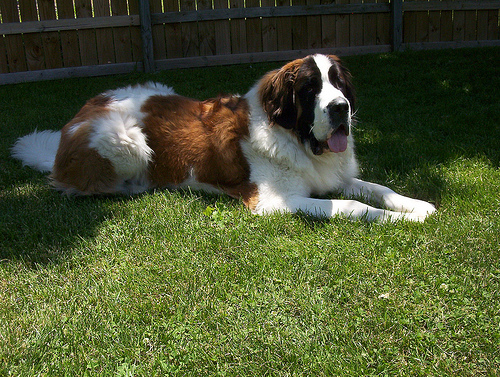

In [152]:
# 랜덤 index설정 
rnd_idx = random.randint(1, len(image_files))
fname = image_files[rnd_idx]
fpath = os.path.join(image_dir, fname)

#이미지 보기
image = Image.open(fpath)
image

In [153]:
# file name 에서 class 가져오기
class_list = set()
for image_file in image_files:
  file_name = os.path.splitext(image_file)[0]
  class_name = re.sub('_\d+', '', file_name) #_숫자 제거 
  class_list.add(class_name)
class_list = list(class_list)
print('class_list_cnt :',len(class_list))
# 정렬
class_list.sort()
class_list

class_list_cnt : 37


['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [154]:
# class name을 숫자로 변환
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [155]:
# 확인
print(class2idx['Bengal'])
print(class_list[1])

1
Bengal


In [156]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [157]:
# image files 정렬 및 확인 -> 같은 클래스끼리 모여서 나옴
image_files.sort()
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [185]:
cnt = 0
previous_class = ""
for image_file in image_files:
  file_name = os.path.splitext(image_file)[0]
  class_name = re.sub('_\d+', '', file_name)
  if class_name == previous_class: # previous_class이 class_name과 같으면 1추가 
      cnt += 1
  else:
      cnt = 1
  if cnt <= 160: # 160장이 넘어가면 val디렉토리에 넣음  // 클래스당 이미지가 대략 200장 정도
      cpath = train_dir
  else:
      cpath = val_dir
  image_path = os.path.join(image_dir, image_file)
  shutil.copy(image_path, cpath)
  previous_class = class_name

In [186]:
# train, val 경로 설정
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [187]:
# image 확인
print('train_images :',len(train_images), 'val_images :',len(val_images))

train_images : 5920 val_images : 1458


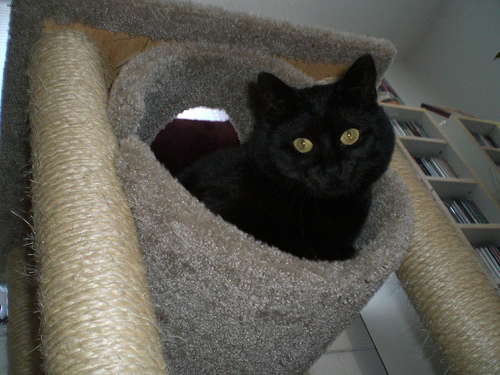

In [188]:
# train_image 확인
fpath = os.path.join(image_dir, train_images[5])
Image.open(fpath)

## TFRecord File 만들기

In [189]:
# img_szie
IMG_SIZE = 224

In [190]:
# TFRecord 저장할 디렉토리와 파일 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [191]:
# TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [192]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.
# 출처 https://www.tensorflow.org/tutorials/load_data/tfrecord
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [193]:
# Training data로 tfrecord 생성
n_train = 0 # 갯수 확인용

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE)) # 리사이즈
  bimage = image.tobytes() # 이미지 byte로 전환

  file_name = os.path.splitext(train_file)[0] # Bangal_101
  class_name = re.sub('_\d+', '', file_name) # _숫자 제거
  class_num = class2idx[class_name] # class_name 숫자로 변경

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num) 
  }))
  writer_train.write(example.SerializeToString()) 
  n_train += 1

writer_train.close() 
print('train :',n_train)

train : 5920


In [194]:
# Validation data로 tfrecord 생성
n_val = 0 # 갯수 확인용

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE)) #리사이즈
  bimage = image.tobytes() # 이미지 byte로 전환

  file_name = os.path.splitext(val_file)[0] # Bangal_101
  class_name = re.sub('_\d+', '', file_name)  # _숫자 제거
  class_num = class2idx[class_name]  # class_name 숫자로 변경

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print('val :',n_val)

val : 1458


## Classification



In [195]:
# Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 50
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH)) #np.ceil 소숫점올림 -> 남은데이터사용

In [196]:
# tfrecord file을 data로 파싱해주는 함수
def _parse_function(tfrecord_serialized):
  features={'image': tf.io.FixedLenFeature([], tf.string), #image
            'cls_num': tf.io.FixedLenFeature([], tf.int64) #class name
            }
  parsed_features = tf.io.parse_single_example(tfrecord_serialized, features) # 파싱
  
  image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
  image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3]) # reshape
  image = tf.cast(image, tf.float32)/255.   #preprocessing

  label = tf.cast(parsed_features['cls_num'], tf.int64)
  label = tf.one_hot(label, N_CLASS)

  return image, label #이미지 라벨 리턴

In [197]:
# train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat() # shuffle, prefetch

In [198]:
# validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

## MobileNetV2

In [199]:
# Model 불러오기
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [200]:
# summary
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [201]:
# model 생성
def create_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())  
  model.add(Dense(N_CLASS, activation='softmax'))
  return model

In [202]:
# Create model, compile & summary
model = create_model()

# learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [203]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/50
148/148 [==============================] - 36s 210ms/step - loss: 1.2306 - accuracy: 0.6946 - val_loss: 0.5739 - val_accuracy: 0.8230
Epoch 2/50
148/148 [==============================] - 32s 206ms/step - loss: 0.2469 - accuracy: 0.9345 - val_loss: 0.4041 - val_accuracy: 0.8738
Epoch 3/50
148/148 [==============================] - 32s 207ms/step - loss: 0.1049 - accuracy: 0.9797 - val_loss: 0.3963 - val_accuracy: 0.8752
Epoch 4/50
148/148 [==============================] - 32s 207ms/step - loss: 0.0509 - accuracy: 0.9946 - val_loss: 0.3504 - val_accuracy: 0.8841
Epoch 5/50
148/148 [==============================] - 32s 207ms/step - loss: 0.0272 - accuracy: 0.9978 - val_loss: 0.3191 - val_accuracy: 0.8909
Epoch 6/50
148/148 [==============================] - 32s 206ms/step - loss: 0.0168 - accuracy: 0.9998 - val_loss: 0.2896 - val_accuracy: 0.9067
Epoch 7/50
148/148 [==============================] - 32s 206ms/step - loss: 0.0143 - accuracy: 0.9993 - val_loss: 0.2710 - val_ac

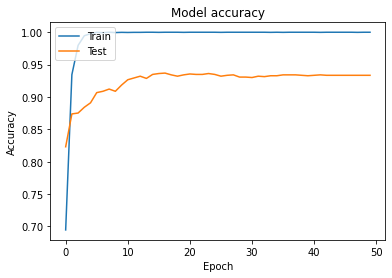

In [225]:
# 6 훈련 과정 시각화 accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model_accuracy.png', dpi=300)

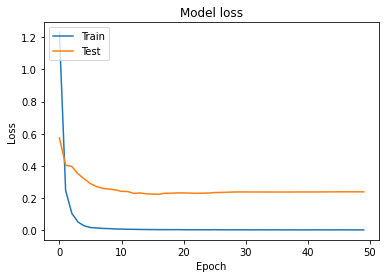

In [224]:
# 7 훈련 과정 시각화 loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model_loss.png', dpi=300)

In [207]:
# 모델 저장
model.save('/content/Image_Classification.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [208]:
# Test
image = Image.open('/content/Shiba.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

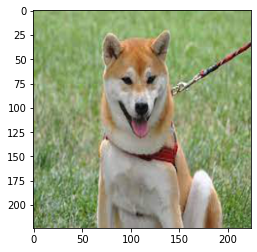

In [209]:
plt.imshow(image)
plt.show()

In [211]:
# prediction
image = np.reshape(image, (1, 224, 224, 3))
prediction = model.predict(image)
prediction.shape

(1, 37)

In [215]:
# 분류 확인 
pred_class = np.argmax(prediction, axis=-1)
class_list[int(pred_class)]

'shiba_inu'